## I- Importation des modules

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
import time
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm

# II- Création des fonctions

## A- MEWE sur la ligne réelle

**Dans cette section, les variables aléatoires sont à valeurs sur la ligne réelle. La distance de Wasserstein est alors calculée de manière exacte et c'est cette expression qui sera utilisé dans l'optimisation. Le modèle est bien spécifié, i.e. la mesure générant les observations et les échantillons pour le calcul de l'estimateur sont les mêmes.**

La première fonction présentée permet de calculer l'estimateur minimisant l'espérance de la distance de Wasserstein. Soit :

\begin{equation}
  \hat{\theta}_{n,m} = \underset{\theta \in \mathcal{H}}{\min} \mathbb{E}_m \mathcal{W}_1(\hat{\mu}_{n}, \hat{\mu}_{\theta,m})^1
\end{equation}

où $\mathcal{W}_1(\mu,\nu)^1$ est la distance de Wasserstein entre deux mesures finies. Nous notons $\hat{\mu}_{n} = \frac{1}{n} \sum_{i=1}^n \delta_{y_i}$ la mesure empirique sur l'échantillon $y_{1:n}$. La mesure empirique de l'échantillon simulée selon la mesure $\mu_{\theta}^{(m)}$ se note $\hat{\mu}_{\theta,m} = \frac{1}{n} \sum_{i=1}^m \delta_{z_i}$ où $z_i \sim \mu_{\theta}^{(m)}$. La particularité de cette fonction est que nous nous situons sur la droite réelle $\mathbb{R}$. Sur cet ensemble, la distance de Wasserstein prend une forme fermée permettant un calcul exact. Cette valeur peut être obtenue en triant dans l'ordre décroissant les vecteurs $y_{1:n}$ et $z_{1:m}$ pour obtenir la collection des statistiques d'ordres $(y_{(i)})_{i=1}^n$ et $(z_{(j)})_{j=1}^n$. En notant $m = nl$ pour $l \geq 1$, la distance de Wasserstein s'exprime comme suit :

\begin{equation}
  \mathcal{W}_1^1(y_{1:n}, z_{1:m}) = \frac{1}{m} \sum_{i=1}^n \sum_{j=1}^l |y_{(i)} - z_{(l(i-1)+j)}|
\end{equation}

L'objectif de l'algorithme sera de calculer $M$ estimateurs résultant de la minimisation de ce programme. Pour ce faire, on spécifie la mesure $\mu_{\theta}^{(m)}$ et nous tirons $N$ échantillon provenant de cette distribution. Puisque nous estimons une espérance, nous calculons cette distance $N$ fois en utilisant les $N$ échantillons provenant de la distribution a priori $\mu_{\theta}^{(m)}$, $\theta$ étant un vecteur de paramètre fixé à l'avance, et nous en faisons la moyenne. La loi des grands nombres nous garantit, si le modèle est bien spécifié une bonne qualité de cette estimation pour l'espérance. L'estimateur étant calculé pour $\theta$ fixé, nous pouvons alors minimiser cette expression selon $\theta$ et le résultat sortant est notre estimateur. Comme déjà dit, on reproduit ces étapes $M$ fois.

Dans nos expériences, nous spécifions un vecteur de taille d'échantillon pour observer comment la qualité de l'estimation évolue lorsque l'on augmente la quantité de données observée.

In [2]:
def mewe(M,N,m,n,target):

  


	"""
		Compute the mewe estimator
		
		Inputs
		------
		M      : Number of estimators
		N      : Number of simulated sample from prior
		m      : Length of the sample from the prior
		n      : Length of the sample observed
		target : List of parameters to detail for the estimation
				 - generate_randomness(nobservations)
					function that generates basic random sample that would be modified by continuous transformation
				 - robservation(theta, randomness)
					function that generates the data observed using a parameter and the randomness from generate_randomness
				 - dist
					a function that specify how the distance is computed between the observed sample and the simulated one
				 - true_theta 
					the parameter used to generate observed data
				 - theta_dim 
					length of the parameter
		
		Outputs
		-------
		pd.DataFrame
	"""
	
	output = []
	for k in tqdm(range(0,M)):
		# Allocate space for output
		mewe_store = np.zeros((len(n),target['thetadim']))
		mewe_runtimes = np.zeros(len(n))
		mewe_evals = np.zeros(len(n))
		
		# generate all observations and sets of randomness to be used
		
		obs_rand = target['generate_randomness'](np.max(n))
		obs_all = target['robservation'](true_theta, obs_rand)
		
		# generate the synthetic randomness, sort.
		
		randomness = [target['generate_randomness'](m) for i in range(N)]
		
		for i in range(0,len(n)):
			# subset observations and sort
			obs = obs_all[:n[i]]
			sort_obs = np.sort(obs)
			sort_obs_mult = np.repeat(sort_obs, m / n[i], axis = 0)
			
			# Define the objective to be minimzed to find the MEWE
			
			def obj1(theta):
				if(theta[1] < 0 ):
					out = 10e6
				else :
					wass_dists = [target['dist'](sort_obs_mult, np.sort(target['robservation'](theta, x))) for x in randomness]
					out = np.mean(wass_dists)
				
				return out
				
			# Optimization
			
			t_mewe = time.process_time()
			mewe = minimize(fun = obj1, x0 = true_theta)
			t_mewe = time.process_time() - t_mewe
			
			# Save the results
			mewe_store[i] = mewe.x
			mewe_runtimes[i] = t_mewe
			mewe_evals[i] = mewe.nit
		
		output_cbind = np.c_[mewe_store, mewe_runtimes, mewe_evals, n, np.arange(len(n))]
		output.append(output_cbind)
		
	return output

**Nous avons pu implémenter l'estimateur du maximum de la distance de Wasserstein sur la ligne réelle et lorsque le modèle est bien spécifié. Nous souhaitons ajouter une nouvelle dimension en considérant le cas où le modèle est mal spécifié.**

## B- MEWE lorsque le modèle est mal spécifié

Travail d'Ottavio, il s'agit de la loi de Cauchy fitté sur un modèle normal dans le papier. Tu peux trouver le code R ici :

https://github.com/pierrejacob/winference/blob/master/inst/reproducepointestimation/cauchydata_normalfit_fixedmk_diffn.R

https://github.com/pierrejacob/winference/blob/master/inst/reproducepointestimation/gamma_normal_fixedmk_diffn.R

Le mewe_cauchy (dans le fichier) est traduit par la fonction mewe du notebook. Néanmoins, y'a juste un endroit qui va changer car le modèle est mal spécifié. Je te laisse coder ça! Même commentaire pour le mewe gamma. L'idéal serait de coder une fonction qui marche pour les deux modèles!

Indication : tu peux ajouter un autre paramètre au dict target qui pourrait être une fonction générant les observations réel et robsertation sera la fonction de la mesure a priori (qui n'est pas la bonne).




In [3]:
def mewe_misspecified(M,N,m,n,target):
	"""
	Compute the mewe estimator for misspecified models
	Inputs
	------
	M      : Number of estimators
	N      : Number of simulated sample from prior
	m      : Length of the sample from the prior
	n      : Length of the observed sample
	target : List of parameters to detail for the estimation
	- generate_randomness(nobservations)
	function that generates basic random sample that would be modified by continuous transformation
	- simulation(theta, randomness)
	function that generates data from the misspecified model, with parameters theta and randomness provided by generate_randomness
	- dist
	a function that specify how the distance is computed between the observed sample and the simulated one
	- true_theta 
	the parameter used to generate observed data
	- observed_law: distribution of observed data (Cauchy or Gamma)
	- theta_dim 
	length of the parameter
	Outputs
	-------
	pd.DataFrame
	"""
	output = []
	for k in tqdm(range(0,M)):
		# Allocate space for output
		mewe_store = np.zeros((len(n),target['thetadim']))
		mewe_runtimes = np.zeros(len(n))
		mewe_evals = np.zeros(len(n))
		
		# generate all observations and sets of randomness to be used
		
		if target["observed_law"] == "Gamma":
			obs_all = np.random.gamma(true_theta[0], true_theta[1],np.max(n))
		elif target["observed_law"] == "Cauchy":
			obs_all = np.random.standard_cauchy(np.max(n))
		else : 
			return("Not implemented law")
			break
		# la ligne du dessus est modifiée pour générer un échantillon contaminé
		
		# generate the synthetic randomness, sort.
		
		randomness = [target['generate_randomness'](m) for i in range(N)]
		
		for i in range(0,len(n)):
			# subset observations and sort
			obs = obs_all[:n[i]]
			sort_obs = np.sort(obs)
			sort_obs_mult = np.repeat(sort_obs, m / n[i], axis = 0)
			
			# Define the objective to be minimized to find the MEWE
			
			def obj1(theta):
				if(theta[1] < 0 ):
					out = 10e6
				else :
					wass_dists = [target['dist'](sort_obs_mult, np.sort(target['simulation'](theta, x))) for x in randomness]
					out = np.mean(wass_dists)
				
				return out
				
			# Optimization
			
			t_mewe = time.process_time()
			mewe = minimize(fun = obj1, x0 = true_theta)
			t_mewe = time.process_time() - t_mewe
			
			# Save the results
			mewe_store[i] = mewe.x
			mewe_runtimes[i] = t_mewe
			mewe_evals[i] = mewe.nit
		
		output_cbind = np.c_[mewe_store, mewe_runtimes, mewe_evals, n, np.arange(len(n))]
		output.append(output_cbind)
		
	return output

## C- MEWE au delà de la ligne réelle

**Nous avons généralisé l'estimation lorsque le modèle était mal spécifié. Nous allons à présent considérer le cas qui se situe au delà de ligne réelle. Cette spécificité ne nous donne plus l'accès à une expression de la distance de Wasserstein facilitant les calculs. Une approximation de la distance de Wasserstein sera alors calculé via le sinkhorn algorithm.**

La deuxième idée est d'aller au délà de la ligne réelle. Néanmoins, sortir de ce cadre apporte une difficulté. En effet, la forme close que nous avons utilisée jusque là ne s'applique plus et le calcul d'une distance de Wasserstein peut se révéler couteux. Néanmoins, il nous est possible d'approximer cette distance en introduisant une version régularisée qui s'écrit sous la forme :

\begin{equation*}
  \gamma^{\zeta} = \underset{\gamma \in \Gamma_{n,m}}{\min} \sum_{i=1}^n \sum_{j=1}^m \rho(y_i, z_j) \gamma_{ij} + \zeta \sum_{i=1}^n \sum_{j=1}^m \gamma_{ij} log \gamma_{ij} 
\end{equation*}

qui inclut une pénalité $\zeta$ sur l'entropie de $\gamma$. Le *sinkhorn algorithm* permet un calcul approché de cette distance avec une complexité de l'ordre de $\mathcal{O}(n^2 log(n))$ lorsque $n=m$. C'est l'objet des fonctions qui suivent lorsque qui performe cet algorithme en assignant un poids uniforme à chaque point du nuage.

In [4]:
def cost_matrix_Lp(x, y, p = 2):
	"""
		Takes two marices of size N1 times d and N2 times d, return an N1 times N2 cost matrix
		
		Inputs
		------
		x : matrix of size N1 times d
		y : matrix of size N2 times d
		p : order of norm
		
		Outputs
		-------
		np.array of size N1 times N2
	"""
	C = np.zeros((x.shape[0], y.shape[0]))
	for i in range(x.shape[0]):
		for j in range(y.shape[0]):
			C[i,j] = np.linalg.norm(x[i] - y[j], ord = p)
	
	return C

def wasserstein(p_, q_, C_, epsilon, niterations):
	"""
		Compute distance between p and q
		p corresponds to the weighs of a N-sample
		each q corresponds to the weights of a M-sample
		Thus cost_matrix must be a N x M cost matrix
		epsilon is a regularization parameter.
		
		Inputs
		------
		p_ 			: weight of a N-sample
		q_ 			: weight of a M-sample
		C_ 			: cost matrix
		epsilon 	: regularization parameter
		niterations : number of iterations
		
		Outputs
		-------
		return a distance and optimal plan
	"""
	N = len(p_)
	M = len(q_)
	
	K = np.exp(-C_ / epsilon)
	
	v = np.ones(M)
	
	for _ in range(1, niterations):
		u = p_ / K.dot(v)
		v = q_ / K.T.dot(u)
	
	transport_matrix = np.diag(u).dot(K).dot(np.diag(v))
	d = np.sum(transport_matrix * C_, axis = 0)
	output = {'distance' : d, 'transport_matrix' : transport_matrix}
	return output


def sinkhorn_distance(x1, x2, p = 1, ground_p = 2, eps = 0.05, niterations = 100):
	"""
		Estimate Wasserstein distance between two clouds
		
		Inputs
		------
		x1 : first cloud
		x2 : second cloud
		p  : order in power
		ground_p : order of cost_matrix
		eps : regularization parameter
		niterations : number of iterations in sinkhorn
		
		Outputs
		-------
		sinkhorn distance
	"""
	w1 = np.repeat(1/x1.shape[0], x1.shape[0])
	w2 = np.repeat(1/x2.shape[0], x2.shape[0])
	C = np.power(cost_matrix_Lp(x1,x2, ground_p),p)
	epsilon = eps * np.median(C)
	wass = wasserstein(w1, w2, C, epsilon, niterations)
	Phat = wass['transport_matrix']
	return np.power((np.sum(Phat * C)),1/p)



def mewe_cloud(M,N,m,n, target):
	"""
		Compute the mewe estimator
		
		Inputs
		------
		M      : Number of estimators
		N      : Number of simulated sample from the prior
		m      : Length of the sample from the prior
		n      : Length of the sample observed
		target : List of parameters to detail for the estimation
				 - generate_randomness(nobservations)
					function thet generate basic random sample that would be modified by continuous transformation
				 - robservation(theta, randomness)
					function that generate the data observed using a parameter and the randomness from generate_randomness
				 - dist
					a function that specify how the distance is computed between the observed sample and the simulated one
				 - true_theta 
					the parameter used for generate observed data
				 - theta_dim 
					length of the parameter
		
		Outputs
		-------
		pd.DataFrame
	"""
	
	output = []
	for k in tqdm(range(0,M)):
		# Allocate space for output
		mewe_store = np.zeros((len(n),target['thetadim']))
		mewe_runtimes = np.zeros(len(n))
		mewe_evals = np.zeros(len(n))
		
		# generate all observations and sets of randomness to be used
		
		obs_rand = target['generate_randomness'](np.max(n))
		obs_all = target['robservation'](true_theta, obs_rand)
		
		# generate the synthetic randomness, sort.
		
		randomness = [target['generate_randomness'](m) for i in range(N)]
		
		for i in range(0,len(n)):
			# subset observations and sort
			obs = obs_all[:n[i]]
			# Define the objective to be minimzed to find the MEWE
			
			def obj1(theta):
				wass_dists = [target['dist'](obs, target['robservation'](theta, x)) for x in randomness] # main shift with the function mewe. The distance used is not the same, we don't sort here.
				out = np.mean(wass_dists)
				
				return out
				
			# Optimization
			
			t_mewe = time.process_time()
			mewe = minimize(fun = obj1, x0 = true_theta)
			t_mewe = time.process_time() - t_mewe
			
			# Save the results
			mewe_store[i] = mewe.x
			mewe_runtimes[i] = t_mewe
			mewe_evals[i] = mewe.nit
		
		output_cbind = np.c_[mewe_store, mewe_runtimes, mewe_evals, n, np.arange(len(n))]
		output.append(output_cbind)
		
	return output

**L'algorithme au delà de la ligne réelle est ainsi implémenté à travers l'ajout de trois fonctions. La plus importante va approximer la distance de Wasserstein entre deux nuages de points où chaque poids est uniforme. L'estimateur sera alors obtenu par l'optimisation de la distance de Wassertein approximé entre le nuage de points observé et l'échantillon simulé selon l'a priori.**

## D- Contamination des données

**L'estimateur MEWE est-il robuste? C'est à cette question que nous essayons de répondre lors de cette section. Pour ce faire, nous proposons deux cas de contaminations et nous modifions l'algorithme d'estimation pour que les données observées soit générées selon cette contamination.**

### a) Fonctions générant les données contaminées

In [5]:
def contamination_huber(theta_1, theta_2, epsilon, randomness, indices = False):
	"""
		Simule une contamination à la Huber lorsque les deux lois
		sont toutes deux gaussiennes mais avec des paramètres différents
		
		Inputs
		------
		N : Nombre d'échantillon que l'on souhaite tirer
		mu_1 : espérance des inliers
		sigma_1 : matrice de covariance de inliers
		mu_2 : espérance des outliers
		sigma_2 : matrice de covariance des outliers
		epsilon : probabilité d'appartenir à l'échantillon des outliers
		
		Outputs
		-------
		X : np.array de dimension d x N
		index : indice observations contaminés
	"""
	N = len(randomness)
	binom = np.random.binomial(1, epsilon, N) # Sample of length N of bernouilli r.v with proba epsilon
	
	X = np.zeros(N) # initialization
	index = np.where(binom == 0) 
	mask = np.ones(N, dtype = bool)
	mask[index] = False # indices of uncontaminated observations
	N_ = N - np.sum(mask) # number of uncontamined observations
	X[~mask] = theta_1[0] + theta_1[1] * randomness[~mask] # sample 
	N_ = np.sum(mask) # number of contaminated observations
	X[mask] = np.sign(np.random.uniform(-1,1, N_))*(theta_2[0] + theta_1[1] * randomness[mask]) # sample
	if indices == False:
		return X
	else :
		return X, mask

def adversarial_contamination(theta_1, theta_2, epsilon, randomness):
	"""
		Simule une contamination adverse lorsque les deux lois
		sont toutes deux gaussiennes mais avec des paramètres différents
		
		Inputs
		------
		N : Nombre d'échantillon que l'on souhaite tirer
		mu_1 : espérance des inliers
		sigma_1 : matrice de covariance de inliers
		mu_2 : espérance des outliers
		sigma_2 : matrice de covariance des outliers
		epsilon : fraction de l'échantillon à corrompre
		
		Outputs
		-------
		X : np.array de dimension d x N
		index : indice observations contaminés
	"""
	N = len(randomness)
	nb_corromp = np.int(N * epsilon)
	X = np.zeros(N)
	X = theta_1[0] + theta_1[1] * randomness
	# L'adversaire rentre dans le jeu de données et va corrompre une fraction epsilon
	index = np.argsort(np.abs(X - theta_1[0]))
	X = X[index] # on trie en fonction de la proximité à mu_1
	# on va retirer les plus petite valeurs et en ajouter des nouvelles selon une nouvelle loi
	X[0:nb_corromp] = np.sign(np.random.uniform(-1,1, nb_corromp))*(theta_2[0] + theta_1[1] * randomness[0:nb_corromp])
	X = np.random.choice(X,len(X), replace = False)
	
	return X

### b) Estimation

In [6]:
def mewe_contamination(M,N,m,n,target):
	"""
		Compute the mewe estimator between the empirical measure and the prior
		
		Inputs
		------
		M      : Number of estimators
		N      : Number of simulated sample from the prior
		m      : Length of the sample from the prior
		n      : Length of the sample observed
		target : List of parameters to detail for the estimation
				 - generate_randomness(nobservations)
					function that generate basic random sample that would be modified by continuous transformation
				 - observation(theta, randomness) :
					function that are really observed. In a well specified model, the function observation and robservation are identical
				 - robservation(theta, randomness)
					function that generate the data observed from the prior measure using a parameter and the randomness from generate_randomness
				 - dist
					a function that specify how the distance is computed between the observed sample and the simulated one
				 - true_theta 
					the parameter used for generate observed data
				 - theta_dim 
					length of the parameter
		
		Outputs
		-------
		pd.DataFrame
	"""
	
	output = []
	for k in tqdm(range(0,M)):
		# Allocate space for output
		mewe_store = np.zeros((len(n),target['thetadim']))
		mewe_runtimes = np.zeros(len(n))
		mewe_evals = np.zeros(len(n))
		
		# generate all observations and sets of randomness to be used
		
		obs_rand = target['generate_randomness'](np.max(n))
		obs_all = target['observation'](target['true_theta'], false_theta, epsilon,obs_rand) 
    # la ligne du dessus est modifiée pour générer un échantillon contaminé
		
		# generate the synthetic randomness, sort.
		
		randomness = [target['generate_randomness'](m) for i in range(N)]
		
		for i in range(0,len(n)):
			# subset observations and sort
			obs = obs_all[:n[i]]
			sort_obs = np.sort(obs)
			sort_obs_mult = np.repeat(sort_obs, m / n[i], axis = 0)
			
			# Define the objective to be minimized to find the MEWE
			
			def obj1(theta):
				if(theta[1] < 0 ):
					out = 10e6
				else :
					wass_dists = [target['dist'](sort_obs_mult, np.sort(target['robservation'](theta, x))) for x in randomness]
					out = np.mean(wass_dists)
				
				return out
				
			# Optimization
			
			t_mewe = time.process_time()
			mewe = minimize(fun = obj1, x0 = true_theta)
			t_mewe = time.process_time() - t_mewe
			
			# Save the results
			mewe_store[i] = mewe.x
			mewe_runtimes[i] = t_mewe
			mewe_evals[i] = mewe.nit
		
		output_cbind = np.c_[mewe_store, mewe_runtimes, mewe_evals, n, np.arange(len(n))]
		output.append(output_cbind)
		
	return output

### c) Médiane des moyennes



Soit $K$ un entier inférieure à n et soit $B_1, \dots, B_K$ une partition de $\{1,\dots,n\}$ en bloc de taille $N/K$ (on suppose que $K$ divise $N$ sinon on retire des données). L'estimateur de la médiane des moyenne est donnée par 

\begin{equation}
  \hat{\mu}_{K}^{MOM} := median(\hat{\mu}_{B_1}, \dots, \hat{\mu}_{B_K})
\end{equation}

Un schéma pour illustrer la méthode que nous allons utiliser :

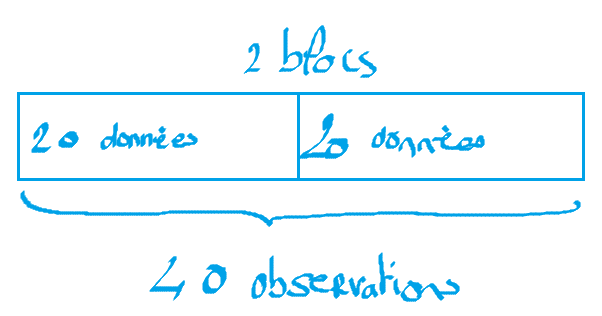

Nous sommes dans un cas où nous avons 20 observations. Ce que nous allons faire est de séparer les 20 observations en K blocs (ici K = 2) afin de pouvoir calculer la médiane des moyennes sur 10 blocs où chaque blocs est composée de deux observations. Ce travail permettra d'obtenir un échantillon de taille K composée de deux médiane des moyennes calculées sur les deux blocs. On calcule ensuite l'estimateur MEWE en optimisant la distance de Wasserstein entre cet échantillon composé des médianes des moyennes et la mesure a priori.

In [7]:
def MoM(obs, K_1):
	"""
		Compute the median of means with K_1 blocks
		
		Inputs
		------
		obs : array of observation
		K_1 : number of blocks, should divide the number of observation, throw away some data if not
		
		Outputs
		-------
		array of length 1
	"""
	
	sample_ = np.random.choice(obs, len(obs))
	n = len(sample_)
	if n % K_1 != 0 :
		N = ( n // K_1 ) * K_1
		sample_ = sample_[0:N]
	sample_ = np.split(sample_, K_1)
	means_ = np.mean(sample_, axis = 1)
	median = np.median(means_)
	return median

def preprocessing(obs, K):
	"""
		return a sample of length K of median of means computed on 10 blocks.
		
		Inputs
		------
		obs : array of observation, must have at least K x K_1 to be computed
		K   : number of blocks, should divide the number of observation, throw away some data if not
		
		Parameters
		----------
		array of length K
	"""
	
	sample = np.random.choice(obs, len(obs), replace = False) # sampling the array
	n = len(sample)
	if n % K != 0 :
		N = ( n // K ) * K
		sample = sample[0:N]
	sample = np.split(sample, K) # split the array in K blocs
	MoMs_ = []
	for x in sample :
		MoMs_.append(MoM(x,10)) # compute the MoM estimator with 10 blocks
	MoMs = np.array(MoMs_)
	return MoMs

def mewe_MOM(M,N,K,m,n,target):
	"""
		Compute the mewe estimator between the empirical measure of MOM and the prior
		
		Inputs
		------
		M      : Number of estimators
		N      : Number of simulated sample from the prior
		m      : Length of the sample from the prior
		n      : Length of the sample observed
		target : List of parameters to detail for the estimation
				 - generate_randomness(nobservations)
					function that generate basic random sample that would be modified by continuous transformation
				 - observation(theta, randomness) :
					function that are really observed. In a well specified model, the function observation and robservation are identical
				 - robservation(theta, randomness)
					function that generate the data observed from the prior measure using a parameter and the randomness from generate_randomness
				 - dist
					a function that specify how the distance is computed between the observed sample and the simulated one
				 - true_theta 
					the parameter used for generate observed data
				 - theta_dim 
					length of the parameter
		
		Outputs
		-------
		pd.DataFrame
	"""
	
	output = []
	for k in tqdm(range(0,M)):
		# Allocate space for output
		mewe_store = np.zeros((len(n),target['thetadim']))
		mewe_runtimes = np.zeros(len(n))
		mewe_evals = np.zeros(len(n))
		
		# generate all observations and sets of randomness to be used
		
		obs_rand = target['generate_randomness'](np.max(n))
		obs_all = target['observation'](target['true_theta'], false_theta, epsilon,obs_rand)
		
		# generate the synthetic randomness, sort.
		
		randomness = [target['generate_randomness'](m) for i in range(N)]
		
		for i in range(0,len(n)):
			# subset observations and sort
			obs_ = obs_all[:n[i]]
			obs = preprocessing(obs_,K) # compute the array of length K using the MoM estimator 
			sort_obs = np.sort(obs)
			sort_obs_mult = np.repeat(sort_obs, m / K, axis = 0)
			
			# Define the objective to be minimized to find the MEWE
			
			def obj1(theta):
				if(theta[1] < 0 ):
					out = 10e6
				else :
					wass_dists = [target['dist'](sort_obs_mult, np.sort(target['robservation'](theta, x))) for x in randomness]
					out = np.mean(wass_dists)
				
				return out
				
			# Optimization
			
			t_mewe = time.process_time()
			mewe = minimize(fun = obj1, x0 = true_theta)
			t_mewe = time.process_time() - t_mewe
			
			# Save the results
			mewe_store[i] = mewe.x
			mewe_runtimes[i] = t_mewe
			mewe_evals[i] = mewe.nit
		
		output_cbind = np.c_[mewe_store, mewe_runtimes, mewe_evals, n, np.arange(len(n))]
		output.append(output_cbind)
		
	return output

**En considérant un cas de contamination à la Huber et adversaire. Nous allons pouvoir attester de la robustesse de l'estimateur aux outliers. Nous proposons de plus une estimation ayant lieu via la médiane des moyennes permettant d'obtenir des meilleurs résultats en présence de données contaminées**

## E- Plot

**Cette section permet de représenter les données estimées. La fonction ci-dessous va représenter le nuage de points des estimations (par exemple $\mu$ et $\sigma$). Chaque point aura une teinte plus foncée selon le nombre d'observation utilisé pour l'estimation.**

In [8]:
def scatter_plot(df, xlabel = r'$\mu$', ylabel = r'$\sigma$', columns = ['mu', 'sigma', 'n'], cmap = 'OrRd', true_theta = None, title = None):
	"""
		plot the scatter plot of the two estimators
		
		Inputs
		------
		df      : pd.DataFrame, must have two estimators in there
		xlabel  : label of x-axis
		ylabel  : label of y-axis
		columns : columns used for the plot
					mu is the mean's estimator
					sigma is the std's estimator
					n is the varying parameter
		cmap    : colormap to be used
		
		Outputs
		-------
		fig, ax
	"""
	cmap = cm.get_cmap(cmap)
	
	# extract all colors form the map
	
	cmaplist = [cmap(i) for i in range(cmap.N)]
	
	# create the new map
	
	cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'Custom cmap', cmaplist, cmap.N)
	bounds = np.linspace(globals()[columns[2]][0],globals()[columns[2]][-1],len(globals()[columns[2]])) # globals() call the variable using only his name.
	norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
	
	# plot the values of the estimators and the true value
	
	fig, ax = plt.subplots()
	ax.scatter(df[columns[0]], df[columns[1]], c = df[columns[2]], cmap = cmap, norm = norm, s=10, alpha = 0.5)
	if true_theta is not None:
		ax.axvline(x = true_theta[0], color = 'grey', lw = 0.5, linestyle = '-') 
		ax.axhline(y = true_theta[1], color = 'grey', lw = 0.5, linestyle = '-')
	ax.set_title(title)
	ax.set_xlabel(xlabel)
	ax.set_ylabel(ylabel)
	return fig, ax

# II- Applications numériques

## A- Somme de variable aléatoire log-Normale

**Nous considérons ici le cas de la section 4.2 du papier concernant la somme de variable aléatoire distribuée selon une loi log-Normal. Pour un entier positif $L$, considérons deux réels $\mu \in \mathbb{R}$ et $\sigma > 0$. Le modèle va générer une observation $y \in \mathbb{R}$ en tirant $x_1, \dots, x_L \sim \mathcal{N}(\mu, \sigma^2)$ de manière indépendante et l'on définit $y = \sum_{l=1}^L exp(x_l)$.**


Nous prenons ici L = 10 et $\theta_* = \begin{pmatrix} 0 \\ 1 \end{pmatrix}$. Nous considérons $m=500$ pour différentes tailles de l'échantillon observé. Lorsque l'on calcul l'espérance, on considére $N = 20$.

In [9]:
np.random.seed(11)

L = 10
target = {}

def generate_randomness(nobservations):
	return (np.random.normal(0,  1, nobservations * L))
	
def robservation(theta, randomness):
	normals_ = theta[0] + theta[1] * randomness
	lognormals_ = np.exp(normals_)
	matrix = lognormals_.reshape(-1,L)
	return(np.sum(matrix, axis = 1))
	
target = {'generate_randomness' : generate_randomness, 'robservation' : robservation}

def metricL1(xvec, yvec):
	return (np.mean(np.absolute(xvec - yvec)))
	
true_theta = [0,1]
target['dist'] = metricL1
target['true_theta'] = true_theta
target['thetadim'] = 2

In [10]:
#Pick m to be larger than or equal to max(n) and a multiple of each entry in n

M = 100
N = 20
m = 500
n = [50,100,250,500]
t = time.process_time()
dataset = mewe(M,N,m,n,target)

100%|██████████| 100/100 [08:16<00:00,  4.97s/it]


In [11]:
t = time.process_time() - t
print(t)
df_mewe = pd.DataFrame(np.concatenate(dataset))
df_mewe.columns = ["mu","sigma","runtime","fn.evals","n","gp"]
df_mewe

496.584232175


,mu,sigma,runtime,fn.evals,n,gp
0,0.180181,0.677979,1.531262,18.0,50.0,0.0
1,0.102106,0.863567,1.087591,11.0,100.0,1.0
2,0.065218,0.916861,1.331359,12.0,250.0,2.0
3,0.024030,0.975884,0.971529,10.0,500.0,3.0
4,-0.221786,1.227381,1.201246,9.0,50.0,0.0
...,...,...,...,...,...,...
395,-0.024673,1.046112,0.983983,10.0,500.0,3.0
396,0.094804,0.941741,1.055999,9.0,50.0,0.0
397,0.014084,0.956386,1.055713,8.0,100.0,1.0
398,0.024182,0.973967,1.346383,17.0,250.0,2.0


Nos estimations sont finies pour ces différents paramètres. Comme indiqué par l'algorithme, il a pris près de 9 minutes à aboutir. Nous proposons de représenter des visualisations des résultats. 

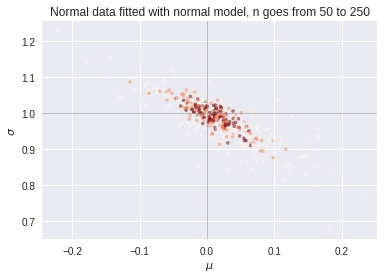

In [12]:
fig, ax = scatter_plot(df_mewe, true_theta = true_theta, title = "Normal data fitted with normal model, n goes from 50 to 250")
plt.show()

Un nuage de point est représenté. Plus les couleurs des points sont chauds et plus la taille de l'échantillon observé est grande. Ainsi, on constate que l'estimation est plus fidèle lorsque la taille de l'échantillon est grand. Nous pouvons obtenir cette observation en constant l'adéquation des lignes grises horizontales et verticales (qui sont les vraies valeurs) et les points.

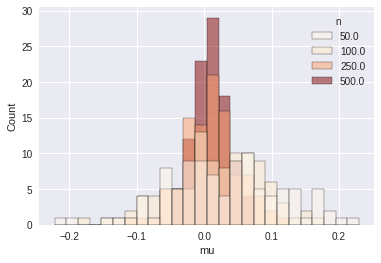

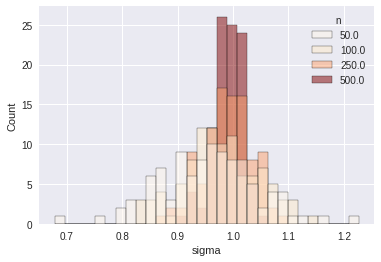

In [13]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('OrRd')
sns.histplot(data = df_mewe, x = "mu", hue = "n", palette= cmap)
plt.show()
sns.histplot(data = df_mewe, x = "sigma", hue = "n", palette= cmap)
plt.show()

Nous voulons savoir si la variance de l'estimation diminue lorsque la taille de l'échantillon augmente. C'est bien ce que nous observons ici.

Bien entendu, par soucis de présentation, nous ne pouvons pas exécuter l'algorithme avec les paramètres utilisés par l'article. C'est pour ça que nous avons fait tourner l'algorithme en local pour une durée proche de 23 heures.

Nous rappelons les paramètres utilisés dans le papier :

M = 1000

N = 20

m = 10**4

n = [50,100,250,500,5000,10000]

In [14]:
! wget https://raw.githubusercontent.com/Aleboul/par_est_wass_dist/main/data/df_mewe.csv

--2021-04-26 16:38:50--  https://raw.githubusercontent.com/Aleboul/par_est_wass_dist/main/data/df_mewe.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 453784 (443K) [text/plain]
Saving to: ‘df_mewe.csv’

df_mewe.csv         100%[===================>] 443.15K  --.-KB/s    in 0.05s   

2021-04-26 16:38:51 (9.44 MB/s) - ‘df_mewe.csv’ saved [453784/453784]



In [15]:
M = 1000
N = 20
m = 10**4
n = [50,100,250,500,1000,5000,1000] # vecteur un peu bizarre mais qui permet seulement de définir les couleurs ici
df_mewe = pd.read_csv('df_mewe.csv')

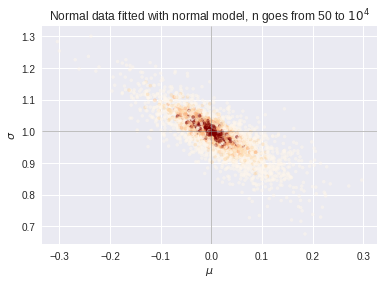

In [16]:
fig, ax = scatter_plot(df_mewe, true_theta = true_theta, title= "Normal data fitted with normal model, n goes from 50 to $10^4$")
plt.show()

Nous observons à nouveau ce qui a été constaté dans l'exemple précédent. Plus la taille de l'échantillon $n$ augmente et plus l'estimation est précise.

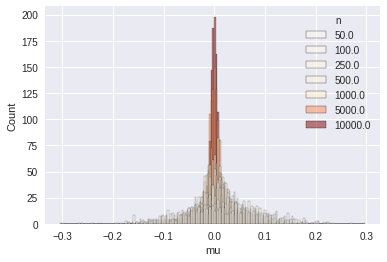

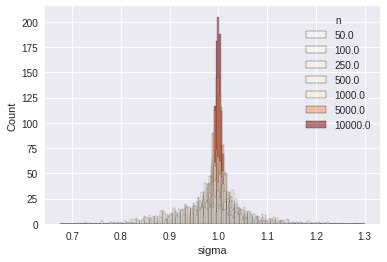

In [17]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('OrRd')
sns.histplot(data = df_mewe, x = "mu", hue = "n", palette= cmap)
plt.show()
sns.histplot(data = df_mewe, x = "sigma", hue = "n", palette= cmap)
plt.show()

La variance diminue avec le nombre d'observation.
Nous allons maintenant vérifier si la normalité asymptotique de notre estimateur lorsqu'il est centré et réduit est vérifié.

In [18]:
df_mewe['mu_scaled'] = (df_mewe.mu - true_theta[0]) * np.sqrt(df_mewe.n)
df_mewe['sigma_scaled'] = (df_mewe.sigma - true_theta[1]) * np.sqrt(df_mewe.n)

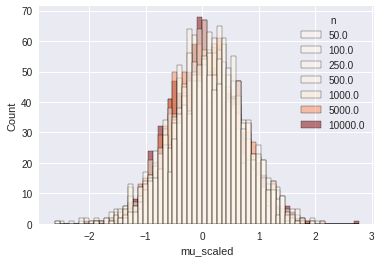

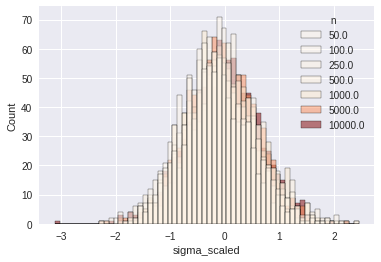

In [19]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('OrRd')
sns.histplot(data = df_mewe, x = "mu_scaled", hue = "n", palette= cmap)
plt.show()
sns.histplot(data = df_mewe, x = "sigma_scaled", hue = "n", palette= cmap)
plt.show()

La convergence de l'estimateur vers la loi normale semble vérifiée.

**L'estimation lorsque le modèle est bien spécifié est performante. Nous constatons que l'estimation est plus précise lorsque la taille de l'échantillon observée augmente. De plus, la normalité asymptotique de l'estimateur est aussi vérifiée.**

## B- Modèle gamma et mesure a priori Gaussienne

In [20]:
np.random.seed(42)

target = {}

def generate_randomness(nobservations):
	return (np.random.normal(0,  1, nobservations))
	
def gaussian_simulation(theta, x):
	return (theta[0] + theta[1] * x)

	
target = {'generate_randomness' : generate_randomness, 'simulation' : gaussian_simulation}

def metricL1(xvec, yvec):
	return (np.mean(np.absolute(xvec - yvec)))
	
true_theta = [10,1/5]
target['dist'] = metricL1
target['true_theta'] = true_theta
target['thetadim'] = 2
target['observed_law'] = 'Gamma'

In [21]:
M = 100
N = 20
m = 500
n = [50,100,250,500]
t = time.process_time()
dataset = mewe_misspecified(M,N,m,n,target)

100%|██████████| 100/100 [02:20<00:00,  1.41s/it]


In [22]:
df_mewe = pd.DataFrame(np.concatenate(dataset))
df_mewe.columns = ["mu","sigma","runtime","fn.evals","n","gp"]
df_mewe

,mu,sigma,runtime,fn.evals,n,gp
0,1.984890,0.460133,0.354296,11.0,50.0,0.0
1,1.967508,0.504812,0.352347,17.0,100.0,1.0
2,2.004399,0.571326,0.557522,15.0,250.0,2.0
3,1.981030,0.590323,0.434173,14.0,500.0,3.0
4,1.859138,0.557650,0.195541,18.0,50.0,0.0
...,...,...,...,...,...,...
395,1.974880,0.605978,0.430222,15.0,500.0,3.0
396,2.034900,0.532756,0.329098,14.0,50.0,0.0
397,2.077699,0.640896,0.384106,16.0,100.0,1.0
398,2.028985,0.610276,0.564408,19.0,250.0,2.0


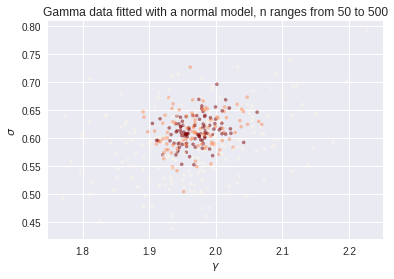

In [23]:
fig, ax = scatter_plot(df_mewe, xlabel = r'$\gamma$', title = "Gamma data fitted with a normal model, n ranges from 50 to 500")
plt.show()

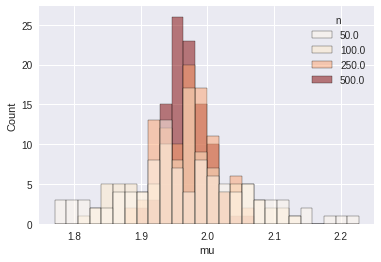

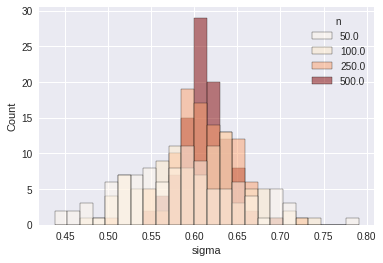

In [24]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('OrRd')
sns.histplot(data = df_mewe, x = "mu", hue = "n", palette= cmap)
plt.show()
sns.histplot(data = df_mewe, x = "sigma", hue = "n", palette= cmap)
plt.show()


Les illustrations peuvent être obtenus en tournant le modèle en local et en extrayant les données de notre git. Ce qui est l'objet des lignes suivantes : présenter des résultats similaires avec un éventail plus large de taille d'échantillon.

In [25]:
! wget https://raw.githubusercontent.com/Aleboul/par_est_wass_dist/main/data/df_gamma.csv

--2021-04-26 16:41:22--  https://raw.githubusercontent.com/Aleboul/par_est_wass_dist/main/data/df_gamma.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 434161 (424K) [text/plain]
Saving to: ‘df_gamma.csv’

df_gamma.csv        100%[===================>] 423.99K  --.-KB/s    in 0.04s   

2021-04-26 16:41:23 (9.49 MB/s) - ‘df_gamma.csv’ saved [434161/434161]



In [26]:
M = 1000
N = 20
m = 10**4
n = [50,100,250,500,1000,5000,1000] # vecteur un peu bizarre mais qui permet seulement de définir les couleurs ici
df_mewe = pd.read_csv('df_gamma.csv')

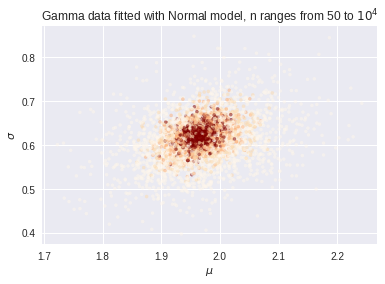

In [27]:
fig, ax = scatter_plot(df_mewe, xlabel= r'$\mu$', title = "Gamma data fitted with Normal model, n ranges from 50 to $10^4$", cmap = 'OrRd')
plt.show()

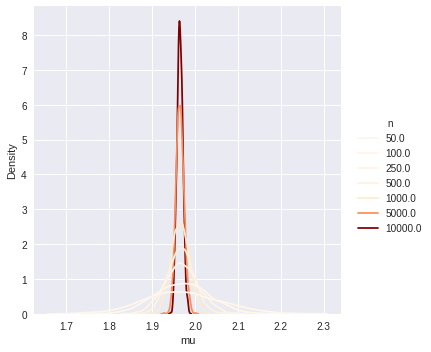

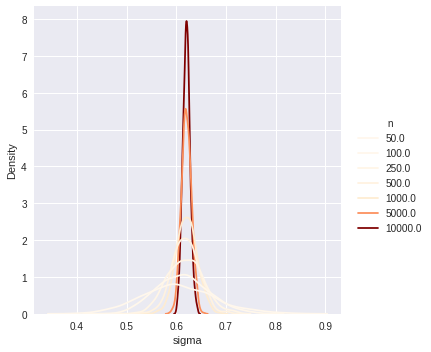

In [28]:
cmap = cm.get_cmap('OrRd')
sns.displot(data = df_mewe, x = "mu", hue = "n", palette= cmap, kind = 'kde')
plt.show()
sns.displot(df_mewe, x = "sigma", hue = "n", palette= cmap, kind = 'kde')
plt.show()

## C- Modèle de Cauchy et mesure a priori Gaussienne

In [29]:
np.random.seed(11)

target = {}

def generate_randomness(nobservations):
	return (np.random.normal(0,  1, nobservations))
	
def gaussian_simulation(theta, x):
	return(theta[0] + theta[1] * x)

	
target = {'generate_randomness' : generate_randomness, 'simulation' : gaussian_simulation}

def metricL1(xvec, yvec):
	return (np.mean(np.absolute(xvec - yvec)))
	
target['dist'] = metricL1

target['thetadim'] = 2
target['observed_law'] = "Cauchy"

In [30]:
M = 100
N = 20
m = 500
n = [50,100,250,500]
t = time.process_time()
dataset = mewe_misspecified(M,N,m,n,target)

100%|██████████| 100/100 [02:17<00:00,  1.38s/it]


In [31]:
df_mewe = pd.DataFrame(np.concatenate(dataset))
df_mewe.columns = ["mu","sigma","runtime","fn.evals","n","gp"]
df_mewe

,mu,sigma,runtime,fn.evals,n,gp
0,0.377011,1.683636,0.198376,18.0,50.0,0.0
1,0.279596,2.212276,0.737943,20.0,100.0,1.0
2,0.044305,2.162758,0.507540,15.0,250.0,2.0
3,-0.068043,2.342983,0.425911,10.0,500.0,3.0
4,-0.261592,1.707166,0.729011,17.0,50.0,0.0
...,...,...,...,...,...,...
395,-0.001439,2.432774,0.416822,14.0,500.0,3.0
396,-0.191115,2.456007,0.502924,16.0,50.0,0.0
397,-0.149587,2.111673,0.440662,14.0,100.0,1.0
398,-0.091912,2.138676,0.474745,9.0,250.0,2.0


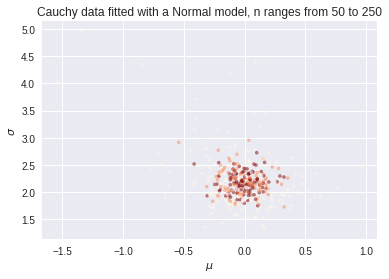

In [32]:
fig, ax = scatter_plot(df_mewe, title = "Cauchy data fitted with a Normal model, n ranges from 50 to 250")
plt.show()

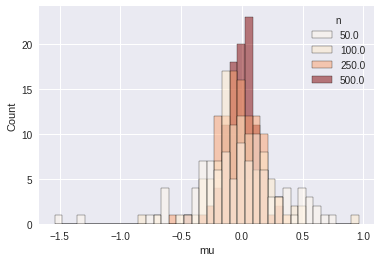

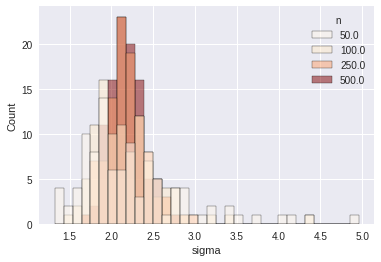

In [33]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('OrRd')
sns.histplot(data = df_mewe, x = "mu", hue = "n", palette= cmap)
plt.show()
sns.histplot(data = df_mewe, x = "sigma", hue = "n", palette= cmap)
plt.show()

La fonction *df_mewe.groupby('n')['sigma'].transform('mean')* permet de calculer la moyenne pour chaque groupe d'observation 'n'. On centre la variable pour chaque moyenne empirique dépendant de la taille d'échantillon.

In [34]:
df_mewe['mu_scaled'] = (df_mewe.mu) * np.sqrt(df_mewe.n)
df_mewe['sigma_scaled'] = (df_mewe.sigma - df_mewe.groupby('n')['sigma'].transform('mean')) * np.sqrt(df_mewe.n)

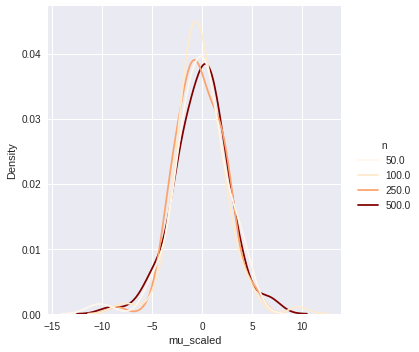

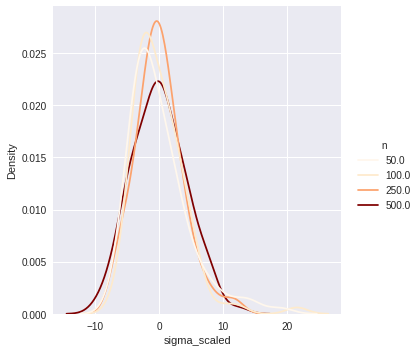

In [35]:
cmap = cm.get_cmap('OrRd')
sns.displot(data = df_mewe, x = "mu_scaled", hue = "n", palette= cmap, kind = 'kde')
plt.show()
sns.displot(df_mewe, x = "sigma_scaled", hue = "n", palette= cmap, kind = 'kde')
plt.show()

In [36]:
! wget https://raw.githubusercontent.com/Aleboul/par_est_wass_dist/main/data/df_cauchy.csv

--2021-04-26 16:43:45--  https://raw.githubusercontent.com/Aleboul/par_est_wass_dist/main/data/df_cauchy.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 445021 (435K) [text/plain]
Saving to: ‘df_cauchy.csv’

df_cauchy.csv       100%[===================>] 434.59K  --.-KB/s    in 0.04s   

2021-04-26 16:43:45 (9.79 MB/s) - ‘df_cauchy.csv’ saved [445021/445021]



In [37]:
M = 1000
N = 20
m = 10**4
n = [50,100,250,500,1000,5000,1000] # vecteur un peu bizarre mais qui permet seulement de définir les couleurs ici
df_mewe = pd.read_csv('df_cauchy.csv')

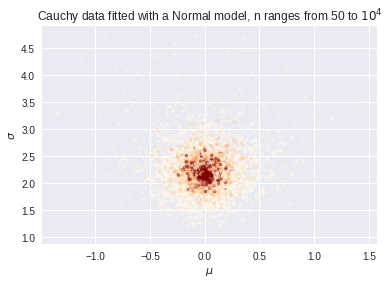

In [38]:
fig, ax = scatter_plot(df_mewe, title = "Cauchy data fitted with a Normal model, n ranges from 50 to $10^4$")
plt.show()

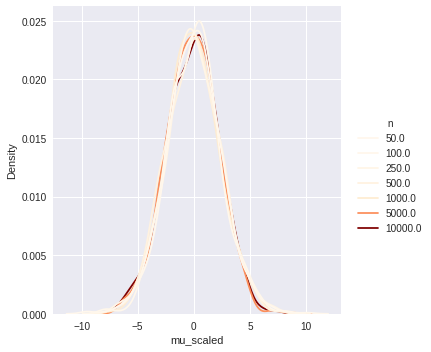

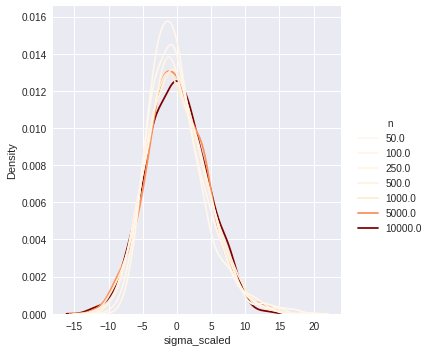

In [39]:
df_mewe['mu_scaled'] = (df_mewe.mu) * np.sqrt(df_mewe.n)
df_mewe['sigma_scaled'] = (df_mewe.sigma - df_mewe.groupby('n')['sigma'].transform('mean')) * np.sqrt(df_mewe.n)
cmap = cm.get_cmap('OrRd')
sns.displot(data = df_mewe, x = "mu_scaled", hue = "n", palette= cmap, kind = 'kde')
plt.show()
sns.displot(df_mewe, x = "sigma_scaled", hue = "n", palette= cmap, kind = 'kde')
plt.show()

## D- Trajectoire d'un mouvement Brownien géométrique

**Dans cette application, nous allons considérer un cas où les données ne sont pas e de façon indépendante. Pour ce cas de figure, le mouvement brownien peut répondre à nos attentes. Il s'agit d'un processus stochastique indexé par la ligne réelle dont les trajectoires sont continues et les accroissement sont stationnaires et indépendants. Malgré l'indépendance des accroissements, les données ne sont pas générés de façon indépendante.**

Ici, nous considérons un mouvement brownien géométrique dont l'expression est donnée par

\begin{equation}
  S_t = S_0 exp((\mu - \frac{\sigma^2}{2})t + \sigma W_t)
\end{equation}

Où $W_t$ est un mouvement brownien standard, $(\mu, \sigma) \in \mathbb{R}\times \mathbb{R}_+$ sont les deux paramètres que l'on souhaite estimer et $S_0$ est une constante positive que nous fixerons à 1. 

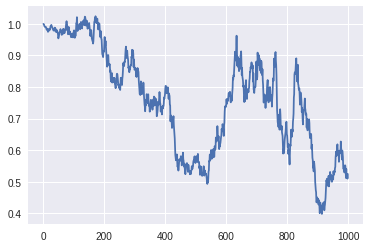

In [40]:
np.random.seed(11)


target = {}

def generate_randomness(nobservations):
	return (np.random.normal(0,  1, nobservations))
 
def robservation(theta, randomness):
	nobservations = np.int(len(randomness))
	dt = 1 / nobservations
	t = np.linspace(0,1, nobservations)
	W_ = np.sqrt(t) * randomness
	W_ = np.cumsum(W_)*np.sqrt(dt)
	X_ = (theta[0] - 0.5*theta[1]**2)*t + theta[1]*W_
	S_ = np.exp(X_)
	return S_
	
ra = generate_randomness(1000)
ob = robservation([0,1], ra)
import matplotlib.pyplot as plt
plt.plot(ob)
plt.show()
	
target = {'generate_randomness' : generate_randomness, 'robservation' : robservation}

# Commentaire 03/04/2021 : รงa marche bien.

def metricL1(xvec, yvec):
	return (np.mean(np.absolute(xvec - yvec)))
	
true_theta = [0,1]
target['dist'] = metricL1
target['true_theta'] = true_theta
target['thetadim'] = 2

Voici une réalisation du mouvement Brownien géométrique. Clairement, les données ne sont pas indépendantes car l'observation au temps t dépend des observations ayant lieu auparavant. L'idée de l'algorithme sera de comparer l'espérance de la distance de Wasserstein entre cette observation et les différentes autres trajectoires simulés. On applique l'algorithme comme si l'on était dans un cas i.i.d. Ce qui est incorrect ici.

In [41]:
N = 20
m = 500
n = [50,100,250,500]
M = 20

import time
t = time.process_time()
dataset = mewe(M,N,m,n,target)
t = time.process_time() - t
print(t)
df_brownian = pd.DataFrame(np.concatenate(dataset))
df_brownian.columns = ["mu","sigma","runtime","fn.evals","n","gp"]
print(df_brownian)

100%|██████████| 20/20 [00:45<00:00,  2.30s/it]

46.13857707500006
          mu     sigma   runtime  fn.evals      n   gp
0   0.089145  0.166020  0.322614       2.0   50.0  0.0
1   0.038858  0.000486  0.372138       3.0  100.0  1.0
2  -0.193147  0.216465  0.802676      13.0  250.0  2.0
3  -0.630528  0.003657  0.844388      18.0  500.0  3.0
4   0.051941  0.001637  0.295959       5.0   50.0  0.0
..       ...       ...       ...       ...    ...  ...
75  0.865256  0.001970  0.606248       2.0  500.0  3.0
76  0.006067  0.018739  1.037311      20.0   50.0  0.0
77  0.031983  0.000309  0.452485       5.0  100.0  1.0
78 -0.335648  0.009524  0.520798      20.0  250.0  2.0
79 -0.482959  0.004681  0.813818      17.0  500.0  3.0

[80 rows x 6 columns]


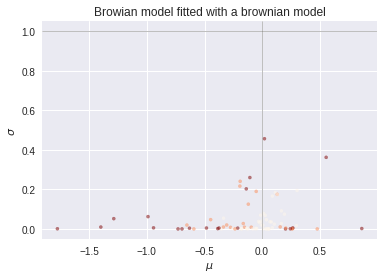

In [42]:
fig, ax = scatter_plot(df_brownian, true_theta = true_theta, title = "Browian model fitted with a brownian model")
plt.show()

Les résultats ne sont pas bons. Nous ne pouvons tirer aucunes conclusion quand à l'efficacité de l'estimateur lorsque la trajectoire observée augmente ni à la normalité ou la variance de celui-ci. Les auteurs ont montré que des bonnes propriétés étaient vérifiées lorsque l'on considérait un processus AR(1). Ce cas de figure semble être un cas particulier car lorsque l'on utilise un processus un peu erratique, aucunes conclusion ne semble tenir lorsque l'on applique l'algorithme de manière naïve (sans aucune modification des données au préalable).

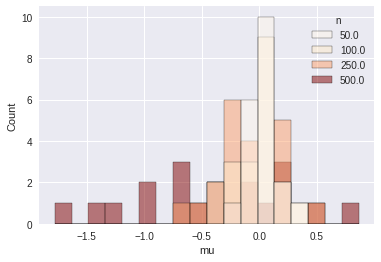

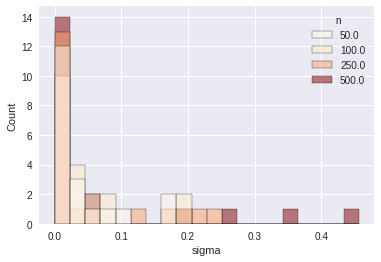

In [43]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('OrRd')
sns.histplot(data = df_brownian, x = "mu", hue = "n", palette= cmap)
plt.show()
sns.histplot(data = df_brownian, x = "sigma", hue = "n", palette= cmap)
plt.show()

**L'application à des données observées qui ne sont pas indépendamment et identiquement distribuées ne permet pas l'estimation des paramètres de la loi.**

## E- Vecteur aléatoire Gaussien

**Nous venons ici à l'application de l'algorithme lorsque d > 1. Nous considérons un modèle bien spécifié. Les observations seront tirées selon un vecteur gaussien dans $\mathbb{R}^2$ de moyenne $\begin{pmatrix} 0 \\ 0 \end{pmatrix}$ et de matrice de covariance l'identité.**

De même, les données simulées pour calculer la distance de Wasserstein seront eux aussi tiré selon cette loi. Ce que nous souhaitons estimé ici est le vecteur de moyenne.

Un inconvénient de cette généralisation est l'augmentation importante du temps de calcul. Ici, nous prenons en compte seulement des tailles d'échantillon relativement petit comparé au cas où nous étions situé sur la ligne réelle.

In [44]:
np.random.seed(11)

target = {}

def generate_randomness(nobservations):
	return (np.random.multivariate_normal([0,0],  [[1,0],[0,1]], nobservations))
def robservation(theta, randomness):
  normals_ = theta + randomness
  return normals_
	
target = {'generate_randomness' : generate_randomness, 'robservation' : robservation}

true_theta = [1,1]
target['thetadim'] = 2
target['dist'] = sinkhorn_distance
target['true_theta'] = true_theta

#Pick m to be larger than or equal to max(n) and a multiple of each entry in n

M = 20
N = 20
m = 15
n = [5,10,15]

Une exécution de 10 minutes aura lieu.

In [45]:
t = time.process_time()
dataset = mewe_cloud(M, N, m, n, target)
t = time.process_time() - t
df_mewe = pd.DataFrame(np.concatenate(dataset))
df_mewe.columns = ["mu","sigma","runtime","fn.evals","n","gp"]

100%|██████████| 20/20 [09:11<00:00, 27.56s/it]


In [46]:
df_mewe

,mu,sigma,runtime,fn.evals,n,gp
0,1.223974,0.234022,0.756013,7.0,5.0,0.0
1,1.040743,0.611196,0.867313,5.0,10.0,1.0
2,1.221058,0.703017,2.430978,9.0,15.0,2.0
3,0.165746,1.727374,0.663508,6.0,5.0,0.0
4,0.355044,1.711715,15.325415,10.0,10.0,1.0
5,0.417027,1.232649,23.061573,10.0,15.0,2.0
6,1.694063,1.427433,1.286571,12.0,5.0,0.0
7,1.333306,1.134558,11.852245,14.0,10.0,1.0
8,1.022967,0.833570,20.950120,15.0,15.0,2.0
9,1.646310,1.210867,0.921108,6.0,5.0,0.0


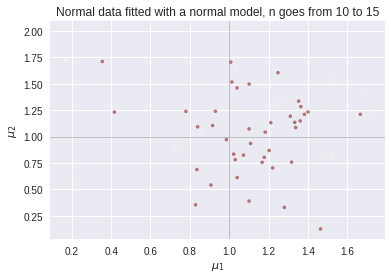

In [47]:
fig, ax = scatter_plot(df_mewe, xlabel = r'$\mu_1$', ylabel=r'$\mu_2$', true_theta = true_theta, title = "Normal data fitted with a normal model, n goes from 10 to 15")
plt.show()

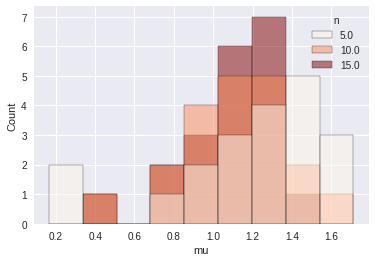

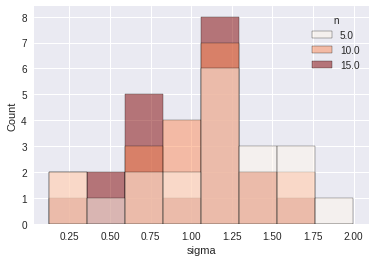

In [48]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('OrRd')
sns.histplot(data = df_mewe, x = "mu", hue = "n", palette= cmap)
plt.show()
sns.histplot(data = df_mewe, x = "sigma", hue = "n", palette= cmap)
plt.show()

On voit des choses, mais avoir un échantillon plus grand serait plus approprié. Nous avons fait tourner des simulations en local et voici les résultats pour les paramètres :

M = 20

N = 20

m = 30

n = [5,10,15,20,25,30]

In [49]:
! wget https://raw.githubusercontent.com/Aleboul/par_est_wass_dist/main/data/df_cloud.csv
df_mewe = pd.read_csv('df_cloud.csv')

--2021-04-26 16:53:46--  https://raw.githubusercontent.com/Aleboul/par_est_wass_dist/main/data/df_cloud.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 36546 (36K) [text/plain]
Saving to: ‘df_cloud.csv’

df_cloud.csv        100%[===================>]  35.69K  --.-KB/s    in 0.004s  

2021-04-26 16:53:47 (8.30 MB/s) - ‘df_cloud.csv’ saved [36546/36546]



In [50]:
M = 20
N = 20
m = 30
n = [5,10,15,20,25,30]

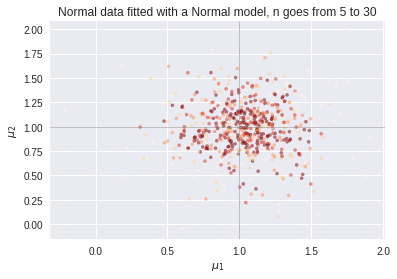

In [51]:
fig, ax = scatter_plot(df_mewe, xlabel = r'$\mu_1$', ylabel=r'$\mu_2$', true_theta = true_theta, title = "Normal data fitted with a Normal model, n goes from 5 to 30")
plt.show()

La précision de l'estimateur n'est pas aussi claire que dans les graphiques précédents lorsque $n$ augmente. Néanmoins, cela est sûrement du au fait que, puisque les calculs prennent du temps, nous ne pouvons considérer des matrices de très grandes dimensions. Ainsi, l'effet de $n$ sur la simulation reste faible puisque nous ne faisons qu'une incrémentation de 5 à chaque étape.
Néanmoins, le nuage de points est concentré autour des vraies valeurs de $\theta$ ce qui apporte une preuve pratique de ce qui a été démontré théoriquement dans le papier : l'estimateur MEWE est consistant au delà de la ligne réelle.

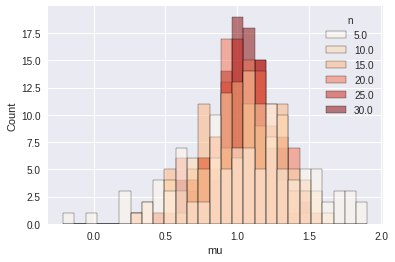

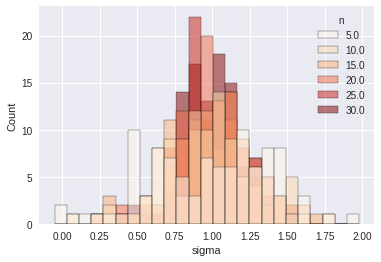

In [52]:
fig, ax = plt.subplots()
cmap = cm.get_cmap('OrRd')
sns.histplot(data = df_mewe, x = "mu", hue = "n", palette= cmap)
plt.show()
sns.histplot(data = df_mewe, x = "sigma", hue = "n", palette= cmap)
plt.show()

**Au delà d'un calcul plus long ce qui nous oblige à réduire le nombre d'observation, l'estimation sur $\mathbb{R}^2$ fonctionne. Les propriétés de l'estimateur observée lorsque les variables aléatoires étaient à valeurs dans la ligne réelle sont conservées. Notamment que la variance de l'estimateur diminue lorsque la taille de l'échantillon observée augmente.**

## F- Nuage Gaussien en dimension 10

**Cette section fait office de terrain de jeu où nous estimons la moyenne d'un vecteur gaussien de dimension 10. Cela permet de vérifier si l'implémentation de notre algorithme a bien été faite.**

In [53]:
np.random.seed(11)

target = {}

def generate_randomness(nobservations):
	return (np.random.multivariate_normal(np.zeros(10), np.eye(10), nobservations))
def robservation(theta, randomness):
  normals_ = theta + randomness
  return normals_
	
target = {'generate_randomness' : generate_randomness, 'robservation' : robservation}

true_theta = np.ones(10)
target['thetadim'] = 10
target['dist'] = sinkhorn_distance
target['true_theta'] = true_theta

#Pick m to be larger than or equal to max(n) and a multiple of each entry in n

M = 1
N = 20
m = 15
n = [15,25,30]

In [54]:
t = time.process_time()
dataset = mewe_cloud(M, N, m, n, target)

100%|██████████| 1/1 [05:41<00:00, 341.04s/it]


In [55]:
t = time.process_time() - t
print(t)
df_mewe = pd.DataFrame(np.concatenate(dataset))
mu = ['mu_' + str(i) for i in range(0,10)]
columns = ["runtime", "fn.evals", "n", "gp"]
columns = mu + columns
df_mewe.columns = columns
df_mewe

344.642085984


,mu_0,mu_1,mu_2,mu_3,mu_4,mu_5,mu_6,mu_7,mu_8,mu_9,runtime,fn.evals,n,gp
0,1.049031,0.686872,1.100201,1.129868,1.050696,0.952545,1.288138,1.332554,0.889028,0.762067,70.416239,35.0,15.0,0.0
1,1.147616,0.857578,0.957105,0.927672,0.846202,0.982094,1.019214,1.346395,0.883003,0.701260,145.760530,41.0,25.0,1.0
2,1.204106,0.930829,0.948096,0.972126,0.952674,0.985401,0.942916,1.314449,0.853962,0.815950,128.435785,39.0,30.0,2.0


**Cela fonctionne.**


## G- Robustesse de l'estimateur

**Nous nous posons la question concernant la robustesse de l'estimateur. La robustesse en statistique est une dimension particulièrement intéressante. Il s'agit de proposer des méthodes d'estimations permettant de limiter l'influence de données extrêmes sur l'estimation.**

### a) Définition du modèle référent

Ce qui est considéré ici est le cas que dit référent, i.e. lorsque les données ne sont pas contaminées. Nous allons générer des observations de ce modèle et estimer l'estimateur MEWE. Ces estimations seront très utiles pour constater les résultats de l'expérience de contamination des données. 

Pour ce faire, nous considérerons ci-dessous que les données non contaminées, les "inliers", seront issues de ce modèle référent.

Le modèle référent est simplement une loi normale centré réduite dont nous essayons d'estimer la moyenne et la variance.

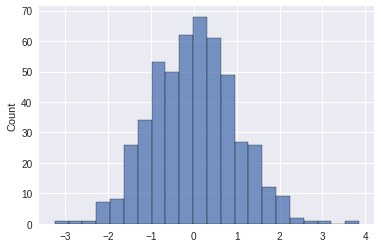

In [56]:
np.random.seed(42)

def generate_randomness(nobservations):
	return (np.random.normal(0,  1, nobservations))
	
def robservation(theta, randomness):
	normals_ = theta[0] + theta[1] * randomness
	return normals_

def metricL1(xvec, yvec):
	return (np.mean(np.absolute(xvec - yvec)))

target = {}

target = {'generate_randomness' : generate_randomness, 'robservation' : robservation}

true_theta = [0,1]
target['dist'] = metricL1
target['true_theta'] = true_theta
target['thetadim'] = 2

M = 100
N = 20
m = 500
n = [50,100,250,500]

obs_rand = target['generate_randomness'](np.max(n))
obs_all = target['robservation'](true_theta,obs_rand)
sns.histplot(obs_all)
plt.show()

In [57]:
t = time.process_time()
dataset = mewe(M,N,m,n, target)
t = time.process_time() - t
print(t)
df_mewe = pd.DataFrame(np.concatenate(dataset))
df_mewe.columns = ["mu","sigma","runtime","fn.evals","n","gp"]
print(df_mewe)

100%|██████████| 100/100 [02:02<00:00,  1.22s/it]

122.22658237400015
           mu     sigma   runtime  fn.evals      n   gp
0   -0.249057  0.887165  0.382830      12.0   50.0  0.0
1   -0.102902  0.897290  0.418339      15.0  100.0  1.0
2   -0.057055  0.978372  0.286722      11.0  250.0  2.0
3    0.035955  0.972500  0.300544      12.0  500.0  3.0
4    0.006899  0.883843  0.081173       8.0   50.0  0.0
..        ...       ...       ...       ...    ...  ...
395  0.016900  1.026678  0.319952       7.0  500.0  3.0
396  0.153803  1.026283  0.279397      10.0   50.0  0.0
397  0.001143  0.908897  0.038073       6.0  100.0  1.0
398 -0.101261  0.993340  0.071134       6.0  250.0  2.0
399 -0.011499  0.976711  0.394710      13.0  500.0  3.0

[400 rows x 6 columns]


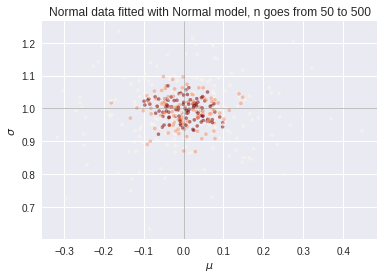

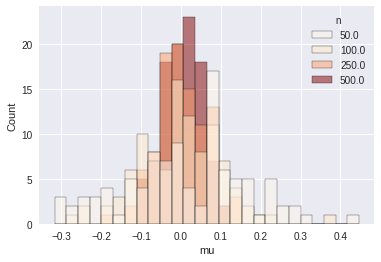

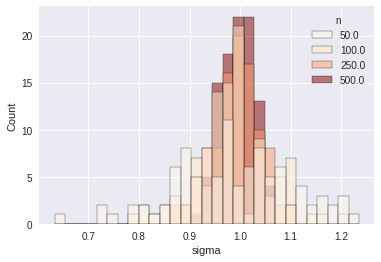

In [58]:
fig, ax = scatter_plot(df_mewe, true_theta = true_theta, title = "Normal data fitted with Normal model, n goes from 50 to 500")
plt.show()
fig, ax = plt.subplots()
cmap = cm.get_cmap('OrRd')
sns.histplot(data = df_mewe, x = "mu", hue = "n", palette= cmap)
plt.show()
sns.histplot(data = df_mewe, x = "sigma", hue = "n", palette= cmap)
plt.show()

### b) Contamination à la Huber

Cette section présente le cas classique de la contamination à la Huber où les données sont tirées de façon i.i.d avec la distribution commune

\begin{equation*}
  dP = (1-\epsilon)dP_i + \epsilon dP_{o}
\end{equation*}
Ici, $P_i$ correspond à la distribution des *inliers* et $P_o$ à la distribution des outliers.
Ici, nous considérons que les *inliers* suivent le modèle référent (pour rappel, un loi normale centrée et réduite). Les outliers vont, quant à eux vont suivre la loi suivante :

\begin{equation*}
  dP_0 = (\frac{1}{2} \delta_{-1} + \frac{1}{2} \delta_{1}) \frac{dG}{d\lambda}
\end{equation*}

Où nous désignons par $\frac{dG}{d\lambda}$ la dérivée (au sens de Radon-Nikodym) par rapport à la mesure de Lebesgue d'une loi normale de moyenne de 10 et de variance 9. En d'autres mots, la loi des outliers est données par le produit d'une loi de Rademacher est d'un gaussienne.

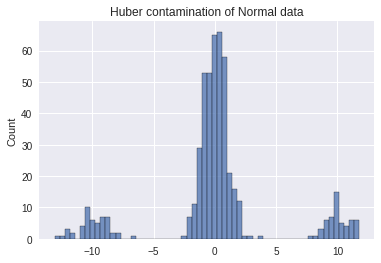

In [59]:
np.random.seed(42)

def generate_randomness(nobservations):
	return (np.random.normal(0,  1, nobservations))
	
def robservation(theta, randomness):
	normals_ = theta[0] + theta[1] * randomness
	return normals_

target = {}

target = {'generate_randomness' : generate_randomness, 'observation' : contamination_huber, 'robservation' : robservation}

true_theta = [0,1]
false_theta = [10,9]
target['dist'] = metricL1
target['true_theta'] = true_theta
target['thetadim'] = 2
epsilon = 0.2

M = 100
N = 20
m = 500
n = [50,100,250,500]

obs_rand = target['generate_randomness'](np.max(n))
obs_all = target['observation'](true_theta, false_theta, 0.2,obs_rand)
sns.histplot(obs_all).set_title('Huber contamination of Normal data')
plt.show()

In [60]:
t = time.process_time()
dataset = mewe_contamination(M,N,m,n, target)
t = time.process_time() - t
print(t)
df_mewe = pd.DataFrame(np.concatenate(dataset))
df_mewe.columns = ["mu","sigma","runtime","fn.evals","n","gp"]
print(df_mewe)

100%|██████████| 100/100 [02:13<00:00,  1.33s/it]

133.08969671800014
           mu     sigma   runtime  fn.evals      n   gp
0    0.162638  1.195068  0.459843      14.0   50.0  0.0
1    0.052391  1.449865  0.398711      19.0  100.0  1.0
2   -0.023887  1.545146  0.469188      20.0  250.0  2.0
3   -0.023442  1.544342  0.426483      10.0  500.0  3.0
4   -0.033564  2.368011  0.081191       8.0   50.0  0.0
..        ...       ...       ...       ...    ...  ...
395 -0.181080  2.015924  0.412908      12.0  500.0  3.0
396 -0.361308  3.261391  0.440832      21.0   50.0  0.0
397 -0.525202  3.303337  0.417641      14.0  100.0  1.0
398 -0.221353  1.548823  0.121873      14.0  250.0  2.0
399 -0.113215  1.662146  0.307933      14.0  500.0  3.0

[400 rows x 6 columns]


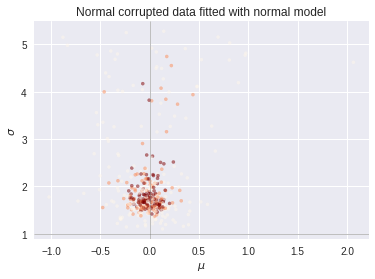

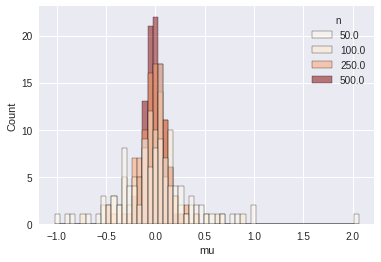

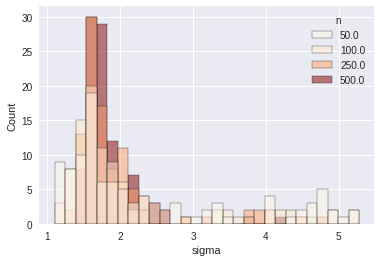

In [61]:
fig, ax = scatter_plot(df_mewe, true_theta = true_theta, title= "Normal corrupted data fitted with normal model")
plt.show()
fig, ax = plt.subplots()
cmap = cm.get_cmap('OrRd')
sns.histplot(data = df_mewe, x = "mu", hue = "n", palette= cmap)
plt.show()
sns.histplot(data = df_mewe, x = "sigma", hue = "n", palette= cmap)
plt.show()

Nous observons deux choses :



*   L'estimateur de la variance est au dessus de sa vraie valeur.
*   La moyenne est correctement estimé dans ce cas où la distribution est symétrique. On constate néanmoins une augmentation de la variance.



### c) Contamination adverse

Nous considérons dans un dernier temps le cas d'une contamination adverse. Ce cas de figure est présenté dans le papier *Robust subgaussian estimation with VC-dimension* en introduction et le processus est le suivant : tiré $N$ échantillon selon une certaine distribution inconnue. Ensuite, un adversaire détient la permission de regarder les échantillons et d'en corrompre une portion $\epsilon$. Dans ce cadre, les outliers peuvent être corrélés entre eux, mais l'intervention de l'adversaire peut créer une dépendance chez les inliers (par exemple, en ne corrompant pas les valeurs les plus grandes lorsque celles-ci sont à valeurs réelles).

Dans ce cas de figure, l'observateur va corrompre les 20\% des valeurs au plus proches de 0 (en considérant la norme euclidienne). Ces données sélectionnées vont alors être modifiées avec un nouveau tirage selon une autre loi normale mais avec des paramètres différents.

Les inliers suivent toujours une loi normale centrée réduite tandis que les outliers suivent la loi donnée par

\begin{equation*}
  dP_0 = (\frac{1}{2} \delta_{-1} + \frac{1}{2} \delta_{1}) \frac{dG}{d\lambda}
\end{equation*}

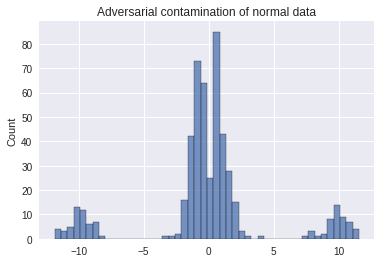

In [62]:
np.random.seed(42)

def generate_randomness(nobservations):
	return (np.random.normal(0,  1, nobservations))
	
def robservation(theta, randomness):
	normals_ = theta[0] + theta[1] * randomness
	return normals_

target = {}

target = {'generate_randomness' : generate_randomness, 'observation' : adversarial_contamination, 'robservation' : robservation}

true_theta = [0,1]
false_theta = [10,9]
target['dist'] = metricL1
target['true_theta'] = true_theta
target['thetadim'] = 2
epsilon = 0.2

M = 100
N = 20
m = 500
n = [50,100,250,500]

obs_rand = target['generate_randomness'](np.max(n))
obs_all = target['observation'](true_theta, false_theta, 0.2,obs_rand)
sns.histplot(obs_all).set_title("Adversarial contamination of normal data")
plt.show()

In [63]:
t = time.process_time()
dataset = mewe_contamination(M,N,m,n, target)
t = time.process_time() - t
print(t)
df_mewe = pd.DataFrame(np.concatenate(dataset))
df_mewe.columns = ["mu","sigma","runtime","fn.evals","n","gp"]
print(df_mewe)

100%|██████████| 100/100 [02:11<00:00,  1.32s/it]

131.4092189959997
           mu     sigma   runtime  fn.evals      n   gp
0    0.203692  2.297444  0.110841      10.0   50.0  0.0
1   -0.012907  2.125088  0.253769      18.0  100.0  1.0
2   -0.010174  2.181039  0.367167      16.0  250.0  2.0
3   -0.045612  2.069501  0.296903       8.0  500.0  3.0
4   -0.177615  1.868706  0.412044      13.0   50.0  0.0
..        ...       ...       ...       ...    ...  ...
395  0.123299  2.105113  0.599152      20.0  500.0  3.0
396 -0.411154  4.378178  0.051786      11.0   50.0  0.0
397 -0.313085  2.284967  0.451191      13.0  100.0  1.0
398 -0.053512  2.335336  0.370204      16.0  250.0  2.0
399 -0.080538  2.037569  0.363980       8.0  500.0  3.0

[400 rows x 6 columns]


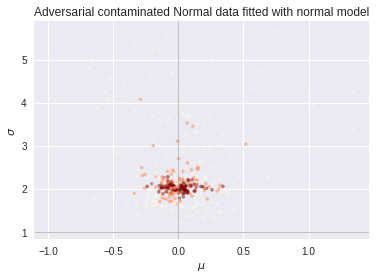

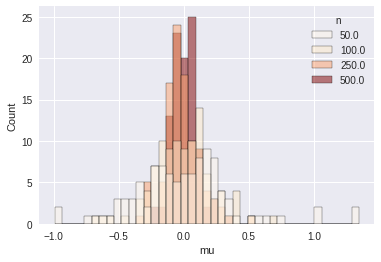

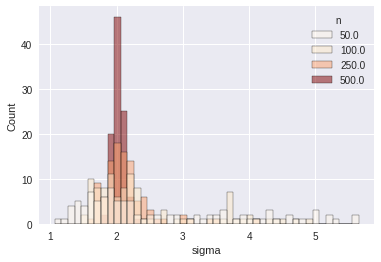

In [64]:
fig, ax = scatter_plot(df_mewe, true_theta = true_theta, title= "Adversarial contaminated Normal data fitted with normal model")
plt.show()
fig, ax = plt.subplots()
cmap = cm.get_cmap('OrRd')
sns.histplot(data = df_mewe, x = "mu", hue = "n", palette= cmap)
plt.show()
sns.histplot(data = df_mewe, x = "sigma", hue = "n", palette= cmap)
plt.show()

Les conclusions que l'on obtient ici sont les mêmes que ceux obtenue lors de la contamination adverse.

### e) Méthode pour réduire la variance de l'estimateur de la moyenne

Nous allons proposer une méthode permettant de réduire la variance de l'estimateur de la moyenne en reprenant le cas de contamination à la Huber. Dans le cas présent, nous avons constaté une augmentation de la variance de l'estimateur de la moyenne suite à l'introduction d'outlier. Nous allons proposer une méthode basée sur le calcul de la médiane des moyennes.

Soit $K$ un entier inférieure à n et soit $B_1, \dots, B_K$ une partition de $\{1,\dots,n\}$ en bloc de taille $N/K$ (on suppose que $K$ divise $N$ sinon on retire des données). L'estimateur de la médiane des moyenne est donnée par 

\begin{equation}
  \hat{\mu}_{K}^{MOM} := median(\hat{\mu}_{B_1}, \dots, \hat{\mu}_{B_K})
\end{equation}

où, pour tout $k \in \{1,\dots, K\}$, $\hat{\mu}_{B_k}$ est définie comme :

\begin{equation}
  \hat{\mu}_{B_k} = \frac{K}{N} \sum_{i \in B_k} X_i
\end{equation}

L'idée que nous proposons est la suivante. Nous souhaitons calculé l'estimateur :

\begin{equation}
  \hat{\theta}_{K,m}^{MOM} = \underset{\theta \in \mathcal{H}}{argmin} \mathbb{E}_m \mathcal{W}_1(\hat{\mu}_{10}^{MOM}, \hat{\mu}_{\theta,m})
\end{equation}

avec $\hat{\mu}_{10}^{MOM} = \frac{1}{K} \sum_{k = 1}^K \delta_{\hat{\mu}_{10,k}^{MOM}}$ est la mesure empirique associé à l'échantillon constitué des $K$ médianes des moyennes réalisées sur la partition de $\{1, \dots, n\}$ où, sur chaque bloc de taille $n / K$, on calcule une médiane des moyennes formé de 10 blocs. On propose la procédure suivante :


1.   Nous tirons un échantillon de taille $n$ à partir de la loi contaminée selon Huber à l'instar de la section correspondante. 
2.   Nous partitionnons en $K$ blocs ces $n$ réalisations.
3.   A l'intérieur de chaque bloc $k \in \{1,\dots, K\}$, on calcul la médiane des moyennes en considérant 10 blocs.
4.   On simule $N$ échantillons de taille $m$ à partir de la mesure à priori (ici une loi normale).
5.   On optimise en $\theta \in \mathbb{R}\times\mathbb{R}_+$ la fonction objectif résultant de la moyenne des distances de Wasserstein entre les K médianes des moyennes et les N réalisations de la mesure à priori. 
6.   Le résultat de l'optimisation correspond à notre estimation.







In [65]:
### Parameters

def generate_randomness(nobservations):
	return (np.random.normal(0,  1, nobservations))

def robservation(theta, randomness):
	normals_ = theta[0] + theta[1] * randomness
	return normals_

def metricL1(xvec, yvec):
	return (np.mean(np.absolute(xvec - yvec)))
	
target = {}

target = {'generate_randomness' : generate_randomness, 'observation' : contamination_huber, 'robservation' : robservation}

true_theta = [0,1]
false_theta = [10,9]
target['dist'] = metricL1
target['true_theta'] = true_theta
target['thetadim'] = 2
epsilon = 0.2

M = 100
N = 20
m = 500
n = [5000,6000,7000,8000]
K = 500 # take a value lower or equal to n / K in order to have at least 10 data within each block
t = time.process_time()
dataset = mewe_MOM(M,N,K,m,n, target)
t = time.process_time() - t
print(t)
df_mewe = pd.DataFrame(np.concatenate(dataset))
df_mewe.columns = ["mu","sigma","runtime","fn.evals","n","gp"]
print(df_mewe)

100%|██████████| 100/100 [02:29<00:00,  1.49s/it]

149.14859198800013
           mu     sigma   runtime  fn.evals       n   gp
0   -0.022869  0.738528  0.367396      15.0  5000.0  0.0
1   -0.040452  0.645081  0.341610      11.0  6000.0  1.0
2   -0.043240  0.654954  0.349753      10.0  7000.0  2.0
3   -0.013536  0.684585  0.433228      18.0  8000.0  3.0
4    0.009441  0.719976  0.414628      10.0  5000.0  0.0
..        ...       ...       ...       ...     ...  ...
395 -0.006788  0.612161  0.405337       9.0  8000.0  3.0
396 -0.017043  0.710083  0.338791      10.0  5000.0  0.0
397  0.038052  0.687358  0.049910       9.0  6000.0  1.0
398 -0.032661  0.646472  0.418833      16.0  7000.0  2.0
399  0.005727  0.646553  0.313850       9.0  8000.0  3.0

[400 rows x 6 columns]


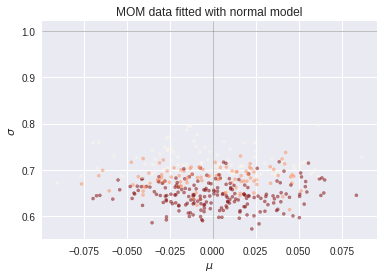

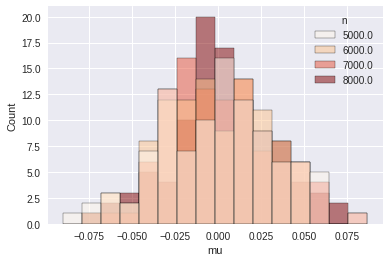

In [66]:
fig, ax = scatter_plot(df_mewe, true_theta = true_theta, title = "MOM data fitted with normal model")
plt.show()
sns.histplot(data = df_mewe, x = "mu", hue = "n", palette= cmap)
plt.show()

Nous avons donc réussi à diminuer la variance en utilisant cette méthode tout en conservant une bonne estimation de $\mu$. Tout cela en estimant avec moins de temps : 2 minutes 32 secondes lorsque l'on fait avec cette procédure et 2 minutes 39 secondes.

Nous pouvons maintenant nous poser la question lorsque nous faisons varier le nombre K de blocs. Pour rappel, il est calculé, dans chaque bloc K, une médiane des moyenne avec 10 blocs. 

Pour ce faire, nous chargeons un jeu données tourné en local où nous prenons $n = 10000$ et $K \in \{25,50,100,250,500\}$.

In [67]:
! wget https://raw.githubusercontent.com/Aleboul/par_est_wass_dist/main/data/df_mom.csv
df_mom = pd.read_csv('df_mom.csv')

--2021-04-26 17:08:31--  https://raw.githubusercontent.com/Aleboul/par_est_wass_dist/main/data/df_mom.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316700 (309K) [text/plain]
Saving to: ‘df_mom.csv’

df_mom.csv          100%[===================>] 309.28K  --.-KB/s    in 0.04s   

2021-04-26 17:08:32 (7.51 MB/s) - ‘df_mom.csv’ saved [316700/316700]



In [68]:
M = 100
N = 20
m = 500
n = 10000
K = [25,50,100,250,500] # take a value lower or equal to n / K in order to have at least 10 data within each block

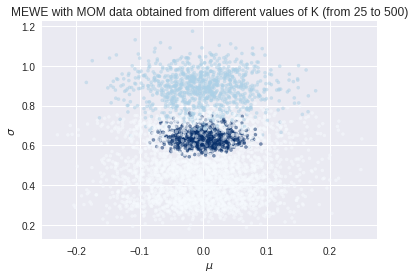

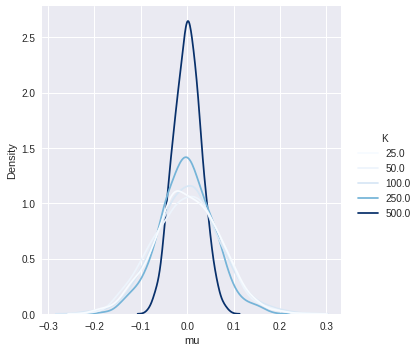

In [69]:
fig, ax = scatter_plot(df_mom, columns = ['mu', 'sigma', 'K'], cmap = "Blues", title= "MEWE with MOM data obtained from different values of K (from 25 to 500)")
cmap = cm.get_cmap('Blues')
sns.displot(data = df_mom, x = "mu", hue = "K", palette= cmap, kind = 'kde')
plt.show()

Le graphique représente le nuage de points constitué de l'estimateur de $\mu$ et $\sigma$ lorsque K varie. La nuance de bleu est plus prononcé lorsque le nombre $K$ est grand.

L'augmentation du nombre K de blocs où nous calculons l'estimateur de la médiane des moyennes permet de réduire la variance de l'estimateur de la moyenne.

**Nos expériences permettent de montrer plusieurs cas de figure où l'estimateur n'est pas robuste. En effet, l'estimation est de moins bonne qualité en présence d'une contamination à la Huber et adverse. La variance est très mal estimée et la moyenne voit sa variance augmentée. Elle reste néanmoins bien estimée mais cela est dû à la symétrie de la loi en la moyenne. Nous avons réussi à proposer une heuristique permettant de réduire la variance de l'estimateur de la moyenne.**